#Tutorial 快速入门
##数据准备
faiss可以处理固定维度d的向量集合，这样的集合这里用二维数组表示。
一般来说，我们需要两个数组：  
1.data。包含被索引的所有向量元素；  
2.query。索引向量，我们需要根据索引向量的值返回xb中的最近邻元素。  
为了对比不同索引方式的差别，在下面的例子中我们统一使用完全相同的数据，即维数d为512，data包含2000个向量，每个向量符合正态分布。  
需要注意的是，faiss需要数组中的元素都是32位浮点数格式。 datatype = 'float32'。

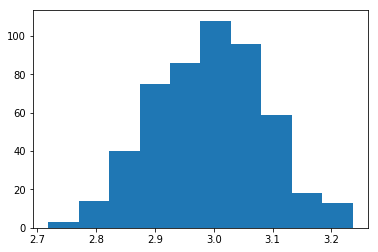

In [2]:
import numpy as np 
d = 512          #维数
n_data = 2000   
np.random.seed(0) 
data = []
mu = 3
sigma = 0.1
for i in range(n_data):
    data.append(np.random.normal(mu, sigma, d))
data = np.array(data).astype('float32')

# print(data[0])

# 查看第六个向量是不是符合正态分布
import matplotlib.pyplot as plt 
plt.hist(data[5])
plt.show()


In [90]:
query = []
n_query = 10
mu = 3
sigma = 0.1
np.random.seed(12) 
query = []
for i in range(n_query):
    query.append(np.random.normal(mu, sigma, d))
query = np.array(query).astype('float32')

##精确索引
在使用faiss时，我们是围绕index对象进行的。index中包含被索引的数据库向量，在索引时可以选择不同方式的预处理来提高索引的效率，表现维不同的索引类型。在精确搜索时选择最简单的IndexFlatL2索引类型。  
IndexFlatL2类型遍历计算查询向量与被查询向量的L2精确距离，不需要训练操作（大部分index类型都需要train操作）。  
在构建index时要提供相关参数，这里是向量维数d，构建完成index之后可以通过add()和search（）进行查询。

In [91]:
import sys
sys.path.append('/home/maliqi/faiss/python/')
import faiss
index = faiss.IndexFlatL2(d)  # 构建index
print(index.is_trained)  # False时需要train
index.add(data)  #添加数据
print(index.ntotal)  #index中向量的个数

True
2000


In [92]:
k = 10  # 返回结果个数
query_self = data[:5]  # 查询本身
dis, ind = index.search(query_self, k)
print(dis)  # 升序返回每个查询向量的距离
print(ind)  # 升序返回每个查询向量的k个相似结果

[[0.       8.007045 8.313328 8.53525  8.560175 8.561642 8.624167 8.628234
  8.709978 8.77004 ]
 [0.       8.27809  8.355579 8.42606  8.462017 8.468868 8.487028 8.549963
  8.562824 8.599199]
 [0.       8.152368 8.156569 8.223303 8.276016 8.376871 8.379269 8.406122
  8.418619 8.443283]
 [0.       8.260519 8.336826 8.339298 8.40288  8.46439  8.474661 8.479043
  8.485248 8.526599]
 [0.       8.346273 8.407202 8.462828 8.49723  8.520801 8.597084 8.600386
  8.605133 8.630594]]
[[   0  798  879  223  981 1401 1458 1174  919   26]
 [   1  981 1524 1639 1949 1472 1162  923  840  300]
 [   2 1886  375 1351  518 1735 1551 1958  390 1695]
 [   3 1459  331  389  655 1943 1483 1723 1672 1859]
 [   4   13  715 1470  608  459  888  850 1080 1654]]


因为查询向量是数据库向量的子集，所以每个查询向量返回的结果中排序第一的是其本身，L2距离是0.

In [93]:
k = 10
dis, ind = index.search(query, k)
print(dis)
print(ind)

[[8.61838   8.782156  8.782816  8.832029  8.837633  8.848496  8.897978
  8.916636  8.919006  8.9374   ]
 [9.033303  9.038907  9.091705  9.15584   9.164591  9.200112  9.201884
  9.220335  9.279477  9.312859 ]
 [8.063818  8.211029  8.306456  8.373352  8.459253  8.459892  8.498557
  8.546464  8.555408  8.621426 ]
 [8.193894  8.211956  8.34701   8.446963  8.45299   8.45486   8.473572
  8.50477   8.513636  8.530684 ]
 [8.369624  8.549444  8.704066  8.736764  8.760082  8.777319  8.831345
  8.835486  8.858271  8.860058 ]
 [8.299072  8.432398  8.434382  8.457374  8.539217  8.562359  8.579033
  8.618736  8.630861  8.643393 ]
 [8.615004  8.615164  8.72604   8.730943  8.762621  8.796932  8.797068
  8.797365  8.813985  8.834726 ]
 [8.377227  8.522776  8.711159  8.724562  8.745737  8.763846  8.768602
  8.7727995 8.786856  8.828224 ]
 [8.342917  8.488056  8.655106  8.662771  8.701336  8.741287  8.743608
  8.770507  8.786264  8.849051 ]
 [8.522164  8.575703  8.68462   8.767247  8.782909  8.850494  8.

##倒排表快速索引
在数据量非常大的时候，需要对数据做预处理来提高索引效率。一种方式是对数据库向量进行分割，划分为多个d维维诺空间，查询阶段，只需要将查询向量落入的维诺空间中的数据库向量与之比较，返回计算所得的k个最近邻结果即可，大大缩减了索引时间。  
nlist参数控制将数据集向量分为多少个维诺空间；  
nprobe参数控制在多少个维诺空间的范围内进行索引。

In [101]:
nlist = 50  # 将数据库向量分割为多少了维诺空间
k = 10
quantizer = faiss.IndexFlatL2(d)  # 量化器
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
       # METRIC_L2计算L2距离, 或faiss.METRIC_INNER_PRODUCT计算内积
assert not index.is_trained   #倒排表索引类型需要训练
index.train(data)  # 训练数据集应该与数据库数据集同分布
assert index.is_trained

index.add(data)
index.nprobe = 50  # 选择n个维诺空间进行索引,
dis, ind = index.search(query, k)
print(dis)
print(ind)

[[8.61838   8.782156  8.782816  8.832029  8.837633  8.848496  8.897978
  8.916636  8.919006  8.9374   ]
 [9.033303  9.038907  9.091705  9.15584   9.164591  9.200112  9.201884
  9.220335  9.279477  9.312859 ]
 [8.063818  8.211029  8.306456  8.373352  8.459253  8.459892  8.498557
  8.546464  8.555408  8.621426 ]
 [8.193894  8.211956  8.34701   8.446963  8.45299   8.45486   8.473572
  8.50477   8.513636  8.530684 ]
 [8.369624  8.549444  8.704066  8.736764  8.760082  8.777319  8.831345
  8.835486  8.858271  8.860058 ]
 [8.299072  8.432398  8.434382  8.457374  8.539217  8.562359  8.579033
  8.618736  8.630861  8.643393 ]
 [8.615004  8.615164  8.72604   8.730943  8.762621  8.796932  8.797068
  8.797365  8.813985  8.834726 ]
 [8.377227  8.522776  8.711159  8.724562  8.745737  8.763846  8.768602
  8.7727995 8.786856  8.828224 ]
 [8.342917  8.488056  8.655106  8.662771  8.701336  8.741287  8.743608
  8.770507  8.786264  8.849051 ]
 [8.522164  8.575703  8.68462   8.767247  8.782909  8.850494  8.

通过改变nprobe的值，发现在nprobe值较小的时候，查询可能会出错，但时间开销很小，随着nprobe的值增加，精度逐渐增大，但时间开销也逐渐增加，当nprobe=nlist时，等效于IndexFlatL2索引类型。  
简而言之，倒排表索引首先将数据库向量通过聚类方法分割成若干子类，每个子类用类中心表示，当查询向量来临，选择距离最近的类中心，然后在子类中应用精确查询方法，通过增加相邻的子类个数提高索引的精确度。

##乘积量化索引
在上述两种索引方式中，在index中都保存了完整的数据库向量，在数据量非常大的时候会占用太多内存，甚至超出内存限制。  
在faiss中，当数据量非常大的时候，一般采用乘积量化方法保存原始向量的有损压缩形式,故而查询阶段返回的结果也是近似的。

In [111]:
nlist = 50
m = 8                             # 列方向划分个数，必须能被d整除
k = 10
quantizer = faiss.IndexFlatL2(d)  
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, 4)
                                    # 4 表示每个子向量被编码为 4 bits
index.train(data)
index.add(data)
index.nprobe = 50
dis, ind = index.search(query_self, k)  # 查询自身
print(dis)
print(ind)
dis, ind = index.search(query, k)  # 真实查询
print(dis)
print(ind)

[[4.8332453 4.916275  5.0142426 5.0211687 5.0282335 5.039744  5.063374
  5.0652556 5.065288  5.0683947]
 [4.456933  4.6813188 4.698038  4.709836  4.72171   4.7280436 4.728564
  4.728917  4.7406554 4.752378 ]
 [4.3990726 4.554667  4.622962  4.6567664 4.665245  4.700697  4.7056646
  4.715714  4.7222314 4.7242   ]
 [4.4063187 4.659938  4.719548  4.7234855 4.727058  4.7630377 4.767138
  4.770565  4.7718883 4.7720337]
 [4.5876865 4.702366  4.7323933 4.7387223 4.7550535 4.7652235 4.7820272
  4.788397  4.792813  4.7930083]]
[[   0 1036 1552  517 1686 1666    9 1798  451 1550]
 [   1  725  270 1964  430  511  598   20  583  728]
 [   2  761 1254  928 1913 1886  400  360 1850 1840]
 [   3 1035 1259 1884  584 1802 1337 1244 1472  468]
 [   4 1557  350  233 1545 1084 1979 1537  665 1432]]
[[5.184828  5.1985765 5.2006407 5.202751  5.209732  5.2114754 5.2203827
  5.22132   5.2252693 5.2286644]
 [5.478416  5.5195136 5.532296  5.563965  5.564443  5.5696826 5.586555
  5.5897493 5.59312   5.5942397]
 [

实验发现，乘积量化后查询返回的距离值与真实值相比偏小，返回的结果只是近似值。  
查询自身时能够返回自身，但真实查询时效果较差，这里只是使用了正态分布的数据集，在真实使用时效果会更好，原因有：  
1.正态分布的数据相对更难查询，难以聚类/降维；  
2.自然数据相似的向量与不相似的向量差别更大，更容易查找；
